In [1]:
# Imports

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OS and helpers
from glob import glob, iglob
from collections import defaultdict
import os
import random
from PIL import Image
import multiprocessing
import time


In [2]:
#Google Colab Import

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/input

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/input


In [3]:
# Settings and hyperparameters

# Image viewing settings
def show_img(img, text=None, should_save=False):
    plt.axis("off")
    if text: plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Loss plot settings
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Hyper Paramters
batch_size=64
epochs=10
img_size=100

##Set core count to total number of cores -1 (could change to half for slower and less taxing performance)
num_workers = max(1, multiprocessing.cpu_count() - 1)


In [4]:
# Pre-resize the images (optional)

# Parameters
dirs = [('../input/train', '../input/train_resized'), ('../input/test', '../input/test_resized')]
new_size = (img_size, img_size)

# Process images
for input_dir, output_dir in dirs:
    for img_path in iglob(f'{input_dir}/**/*.*', recursive=True):
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            relative_path = os.path.relpath(img_path, input_dir)
            output_path = os.path.join(output_dir, relative_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            img = Image.open(img_path)
            img_resized = img.resize(new_size)
            img_resized.save(output_path)

In [5]:
# Exract training and validation images

# Checks to see if the resized images are already available
resized = all(glob(f'{dir}_resized') for dir in ['../input/train', '../input/test'])
train_dataset_path = '../input/train_resized' if resized else '../input/train'
test_dataset_path = '../input/test_resized' if resized else '../input/test'

#Split validation vamilies
val_famillies = "F09"

#An example of data:"../input/train/F0002/MID1/P00010_face4.jpg"
all_images = glob(train_dataset_path+"/*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

#Create combined person/image pairs "F0002/MID1"
person_image_map_train = defaultdict(list)
for x in train_images:
    # Normalize the path to handle different OS path separators
    normalized_path = os.path.normpath(x)

    # Split the normalized path into components
    path_components = normalized_path.split(os.sep)

    # Extract the desired components
    person_id = f"{path_components[-3]}/{path_components[-2]}"

    # Create person to image dictionary
    person_image_map_train[person_id].append(x)

person_image_map_val = defaultdict(list)
for x in val_images:
    # Normalize the path to handle different OS path separators
    normalized_path = os.path.normpath(x)

    # Split the normalized path into components
    path_components = normalized_path.split(os.sep)

    # Extract the desired components
    person_id = f"{path_components[-3]}/{path_components[-2]}"

    # Create person to image dictionary
    person_image_map_val[person_id].append(x)



print("Training images:", len(person_image_map_train))
print("Validation images:", len(person_image_map_val))

Training images: 2085
Validation images: 231


In [6]:
# Create training and validation pairs

# Create a list of all people
person_id=[]
for x in all_images:
    # Normalize the path to handle different OS path separators
    normalized_path = os.path.normpath(x)

    # Split the normalized path into components
    path_components = normalized_path.split(os.sep)

    # Extract the desired components
    person_id.append( f"{path_components[-3]}/{path_components[-2]}")

# Extract all relationships
relationships = pd.read_csv("../input/train_relationships.csv")
relationships = list(zip(relationships.p1.values, relationships.p2.values))

# Filter unused relationships and split between train and val
relationships = [x for x in relationships if x[0] in person_id and x[1] in person_id]
pairs_train = [x for x in relationships if val_famillies not in x[0]]
pairs_val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(pairs_train))
print("Total val pairs:", len(pairs_val))

Total train pairs: 3066
Total val pairs: 296


In [7]:
# Dataset definition
class trainingDataset(Dataset):

    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.relationships = relationships # Choose between train and val
        self.transform = transform

    # Allows setting number of pairs in each epoch
    def __len__(self):
        return len(self.relationships)

    # For each relationship retrieves person and either a related person or random unrelated person
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]
        img0_path = glob(train_dataset_path+'/'+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path)

        # Get related people
        relatives = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]

        # If no relationship, get a random person (shouldn't trigger)
        if relatives==[]:
            assign_related = 0

        # If there are relationships randomly assign either a related person or an unrelated person
        else:
            assign_related = random.randint(0,1)

        # If assigning a relative, get a related person
        if assign_related==1:
            img1_info = random.choice(relatives)
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]

            # Get random image of relative
            img1_path = glob(train_dataset_path+'/'+img1_info+"/*.jpg")
            img1_path = random.choice(img1_path)

        # If assigning non-relative, get an unrelated person
        else:
            # Get a random person and image
            randChoose = True
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]

                # Normalize the path and split into components
                normalized_path = os.path.normpath(img1_path)
                path_components = normalized_path.split(os.sep)

                # Extract and manually info
                img1_info = f"{path_components[-3]}/{path_components[-2]}"

                randChoose = False

                # Check to make sure the random person is not related
                for x in relatives:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        # Any transforms
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , assign_related

In [8]:
# Data loaders

transform_list = [transforms.ToTensor()] if resized else [transforms.Resize((img_size, img_size)), transforms.ToTensor()]


folder_dataset = datasets.ImageFolder(root=train_dataset_path)

train_dataset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=pairs_train,
                                        transform=transforms.Compose(transform_list)
                                        )
val_dataset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=pairs_val,
                                        transform=transforms.Compose(transform_list)
                                        )

train_loader = DataLoader(train_dataset,
                        num_workers=num_workers,
                        batch_size=batch_size,
                        shuffle=True)

val_loader = DataLoader(val_dataset,
                        num_workers=num_workers,
                        batch_size=batch_size,
                        shuffle=True)

In [9]:
# Optional Efficiency tests

image = Image.open(train_dataset_path+"/F0002/MID1/P00010_face4.jpg")

resize_transform = transforms.Resize((100, 100))
to_tensor_transform = transforms.ToTensor()

start_time = time.time()
resized_image = resize_transform(image)
print(f"Resize Time: {time.time() - start_time} seconds")

start_time = time.time()
tensor_image = to_tensor_transform(resized_image)
print(f"ToTensor Time: {time.time() - start_time} seconds")

Resize Time: 0.00016164779663085938 seconds
ToTensor Time: 0.05276322364807129 seconds


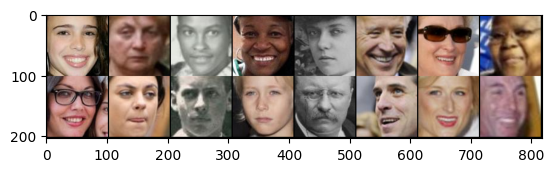

[1 1 0 0 1 1 1 0]


In [10]:
# Optional visualization of images loaded
vis_dataloader = DataLoader(train_dataset,
                        num_workers=num_workers,
                        batch_size=8,
                        shuffle=True)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

# Concatenate each pair of images along the height (dim=1) and make a grid with 8 pairs per row
grid = (
    torchvision.utils.make_grid([torch.cat((img1, img2), 1) for img1, img2 in zip(example_batch[0], example_batch[1])], nrow=8)
    .permute(1, 2, 0)
)

# Display the grid
plt.imshow(grid)
plt.show()

# Print the additional tensor as numpy array
print(example_batch[2].numpy())

In [11]:
# Model Definition
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.3),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.3),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)

        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

CUDA
Epoch:  0  start
Epoch: 0 completed in 55.68410457372666 minutes.
51.35% accuracy on the 296 pairs in F09


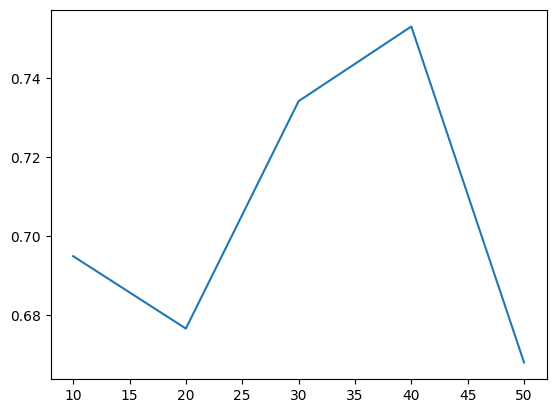

Epoch:  1  start
Epoch: 1 completed in 30.450160801410675 minutes.
55.07% accuracy on the 296 pairs in F09


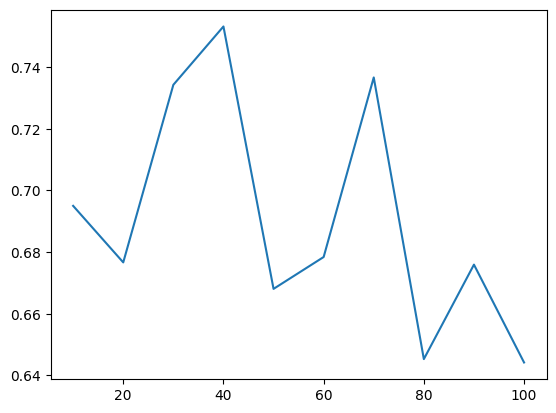

Epoch:  2  start
Epoch: 2 completed in 17.897377614180247 minutes.
56.76% accuracy on the 296 pairs in F09


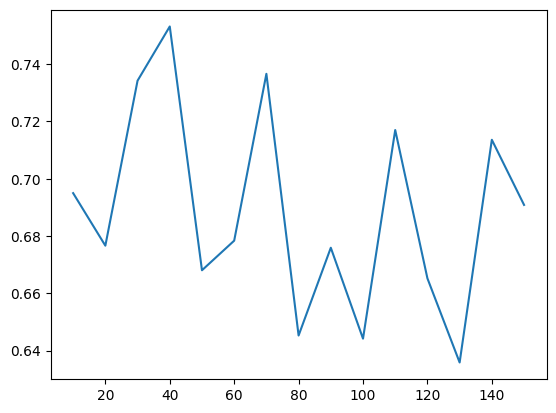

Epoch:  3  start
Epoch: 3 completed in 11.709501365820566 minutes.
63.18% accuracy on the 296 pairs in F09


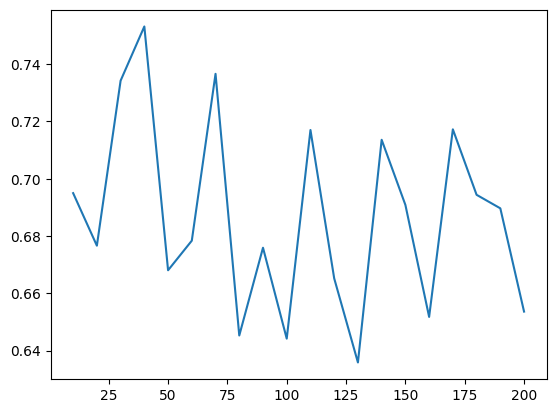

Epoch:  4  start
Epoch: 4 completed in 8.800587451457977 minutes.
59.12% accuracy on the 296 pairs in F09


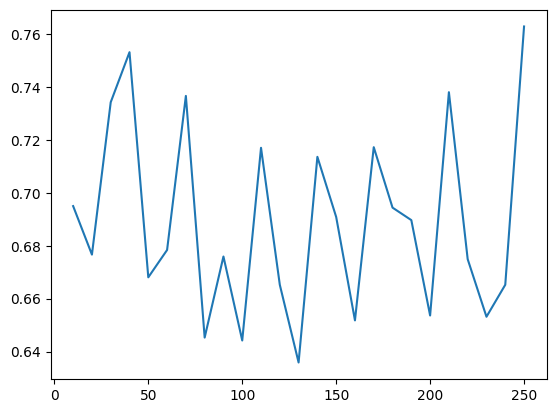

Epoch:  5  start
Epoch: 5 completed in 5.991315484046936 minutes.
56.76% accuracy on the 296 pairs in F09


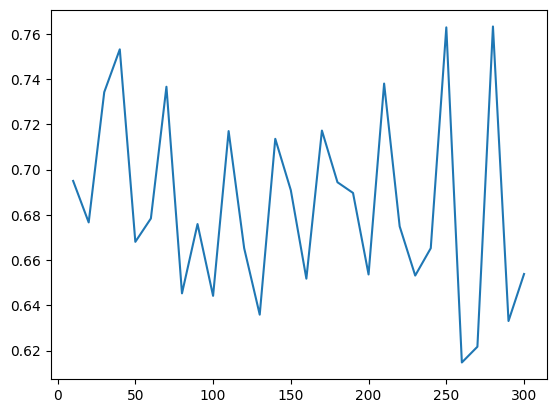

Epoch:  6  start
Epoch: 6 completed in 4.445620890458425 minutes.
61.15% accuracy on the 296 pairs in F09


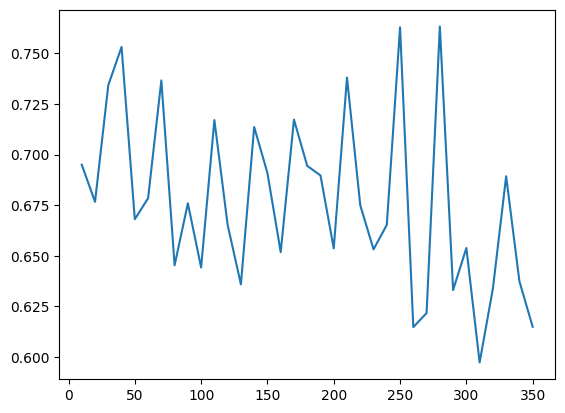

Epoch:  7  start
Epoch: 7 completed in 2.8048282980918886 minutes.
57.43% accuracy on the 296 pairs in F09


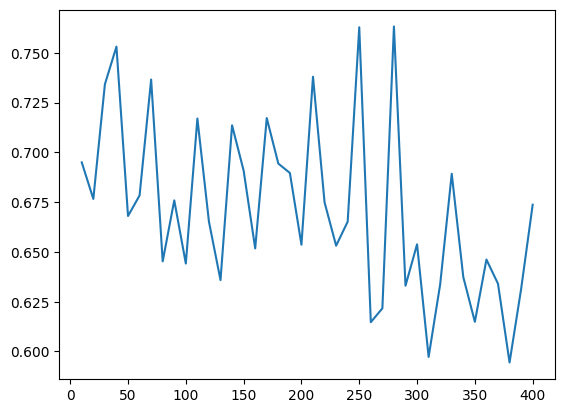

Epoch:  8  start
Epoch: 8 completed in 2.613313448429108 minutes.
56.08% accuracy on the 296 pairs in F09


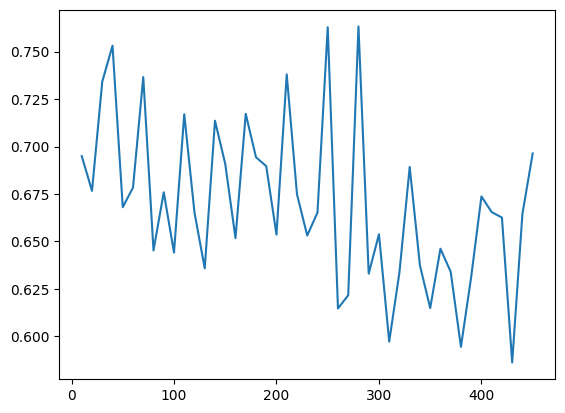

Epoch:  9  start
Epoch: 9 completed in 1.8922833959261576 minutes.
58.11% accuracy on the 296 pairs in F09


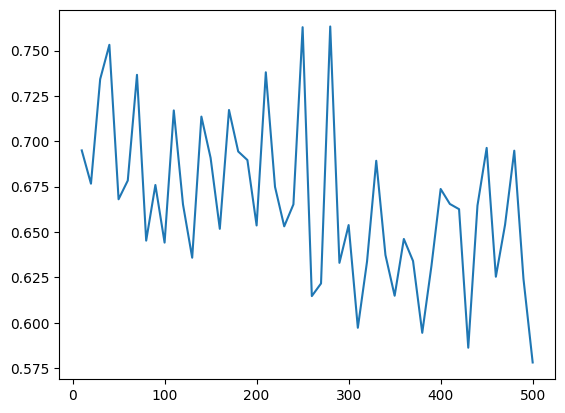

In [13]:
# Run Model and calculate loss
model=SiameseNetwork()

# Check for graphics card and if so use CUDA
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    print("CUDA")

# Cross Entropy Loss with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = []
iteration_number= 0

for epoch in range(0,epochs):
    start_time = time.time()  # Record start time
    print("Epoch: ", epoch, " start")
    for i, data in enumerate(train_loader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        if CUDA:
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
        #print(f"epoch: {epoch} {i} inputs {img0.data.size()} labels {labels.data.size()}")
        optimizer.zero_grad()
        outputs = model(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        #Collect Loss info after every 10 batches
        if i %10 == 0 :
            #print(f"Epoch {epoch}, Current loss {loss.item()}")
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())

    # Test network after each epoch
    epoch_duration = (time.time() - start_time)/60  # Calculate duration
    print("Epoch:", epoch, "completed in", epoch_duration, "minutes.")

    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            img0, img1 , labels = data
            if CUDA:
                img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = model(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    print(f'{100 * correct_val / total_val:.2f}% accuracy on the {total_val} pairs in {val_famillies}')
    show_plot(counter,loss_history)

In [ ]:
class testDataset(Dataset):
    def __init__(self, sample_file, transform=None):
        self.test_df = pd.read_csv(sample_file)
        self.transform = transform

    def __getitem__(self, index):
        img0_path, img1_path = self.test_df.iloc[index].img_pair.split("-")
        img0 = Image.open(test_dataset_path + '/' + img0_path)
        img1 = Image.open(test_dataset_path + '/' + img1_path)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

# Configurations & model placeholder
sample_file = '../input/sample_submission.csv'

# Prepare dataset and dataloader
testset = testDataset(sample_file, transform=transforms.Compose(transform_list))
testloader = DataLoader(testset, shuffle=False, num_workers=0, batch_size=1)

# Make predictions
predictions = []
with torch.no_grad():
    for img0, img1 in testloader:
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = model(img0, img1)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy()[0])

# Update dataframe and save to CSV
test_df = pd.read_csv(sample_file)
test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)
print(test_df.head(50))